In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.ndimage import gaussian_filter

In [2]:
def load_imgs(dir_path):
    imgs = []

    for filename in os.listdir(dir_path):
        if filename.lower().endswith(('.png', '.jpg')):
            img_path = os.path.join(dir_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                imgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else: 
                print(f'failed to load: {img_path}')
    return imgs



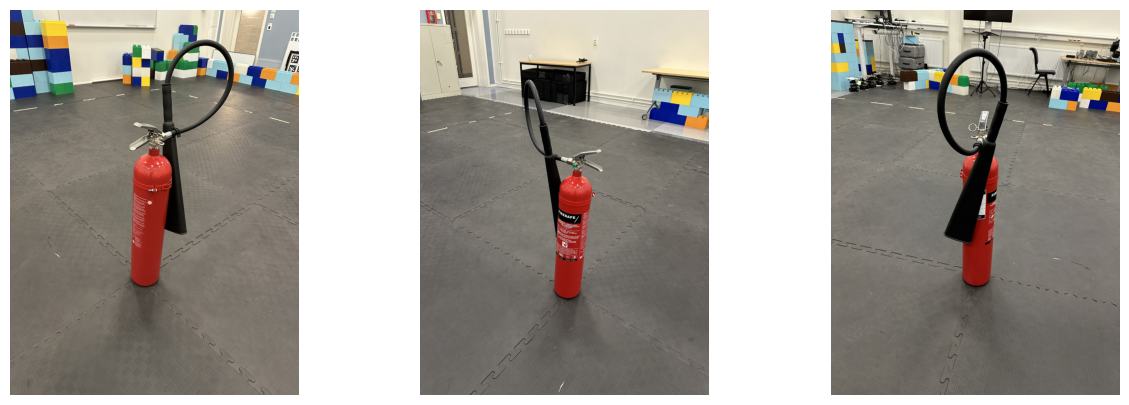

In [3]:
anchor_set = load_imgs('data/Anchor')
image_set = load_imgs('data/camera_color_image_raw')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(anchor_set[i])
    ax.axis('off')


Difference of Gaussians: images are blurred and reduced in size (downsampled) a by factor of 2, images are smaller and more blurred than the last, then the difference of consecutrive images are computed (difference of gaussians)

In [69]:
def get_num_octaves(image_shape):
    # should be 12 for anchor images (~8k x 6k) 
    return int(round(np.log2(min(image_shape[:2])) - 1))



# 1.6 and 3 are what was found to work best in paper
def get_DoGs(image, sigma = 1.6, num_scales = 3):
    num_octaves = get_num_octaves(image.shape)

    # Computes the sigma for each level of blur. Instead of blurring each image n times, 
    # we instead compute the kernel that has the same effect, since convolution is slow
    imgs_per_octave = num_scales + 3
    k = 2 ** (1/num_scales)

    kernel_sigmas = np.zeros(imgs_per_octave) 
    kernel_sigmas[0] = sigma

    for i in range(1, imgs_per_octave):
        sigma_next = sigma * (k ** i)
        kernel_sigmas[i] = sigma_next


    gaussians = []
    for i in range(num_octaves):
        current_octave = []
        current_octave.append(image)
        for _sigma in kernel_sigmas[1:]: # not first one, already added
            # (0,0) kernel size means opencv computes size based on sigma
            image = cv2.GaussianBlur(image, (0, 0), sigmaX = _sigma, sigmaY = _sigma)
            current_octave.append(image)
        gaussians.append(current_octave)

        next_octave_start = current_octave[-3]
        # divide img in half
        next_img_size = (int(next_octave_start.shape[1] / 2), int(next_octave_start.shape[0] / 2))
        image =  cv2.resize(next_octave_start, next_img_size, interpolation=cv2.INTER_NEAREST)


    DoGs = []

    for current_octave in gaussians:
        DoGs_in_octave = [cv2.subtract(current_octave[i + 1], current_octave[i]) for i in range(len(current_octave) - 1)]
        DoGs.append(DoGs_in_octave)
        
    return DoGs, gaussians

num octaves: 12
image shape: (8064, 6048)
[1.6        2.01587368 2.53984168 3.2        4.03174736 5.07968337]


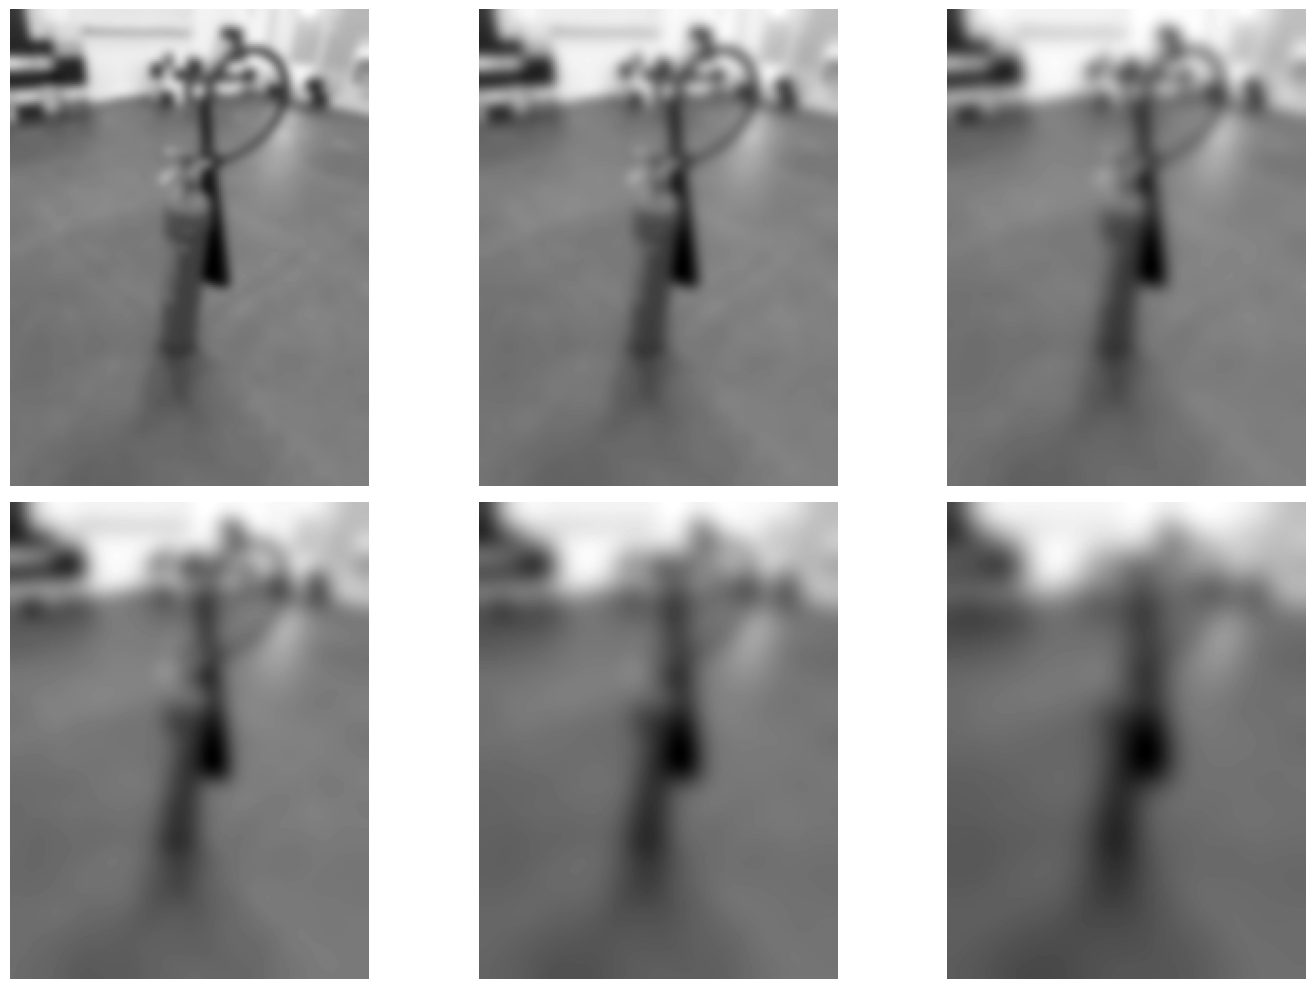

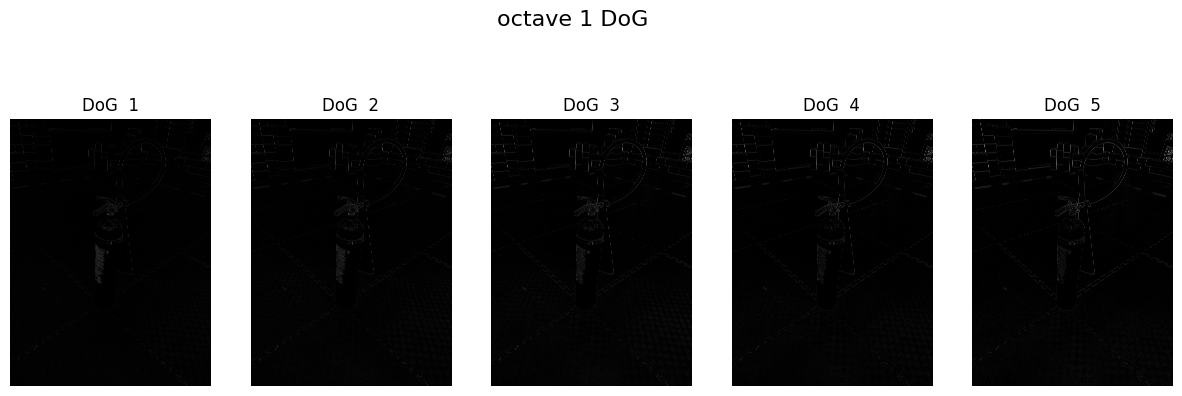

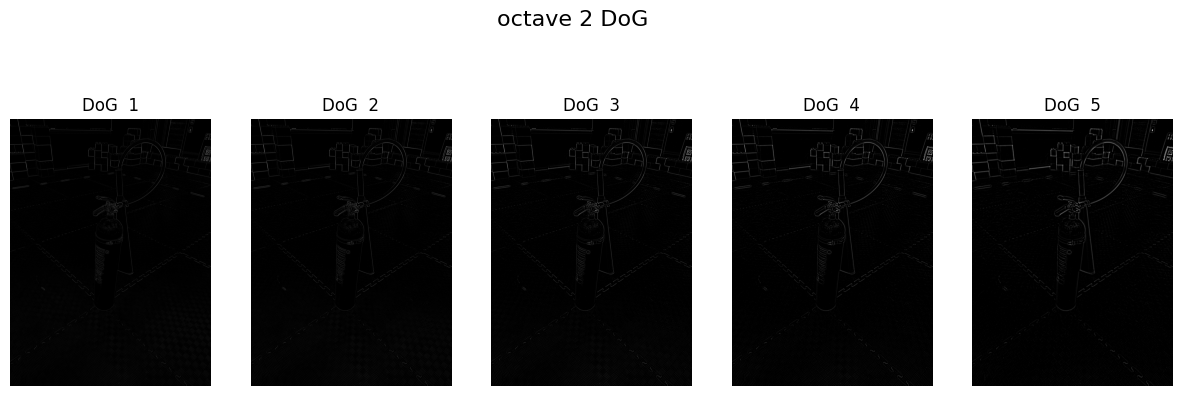

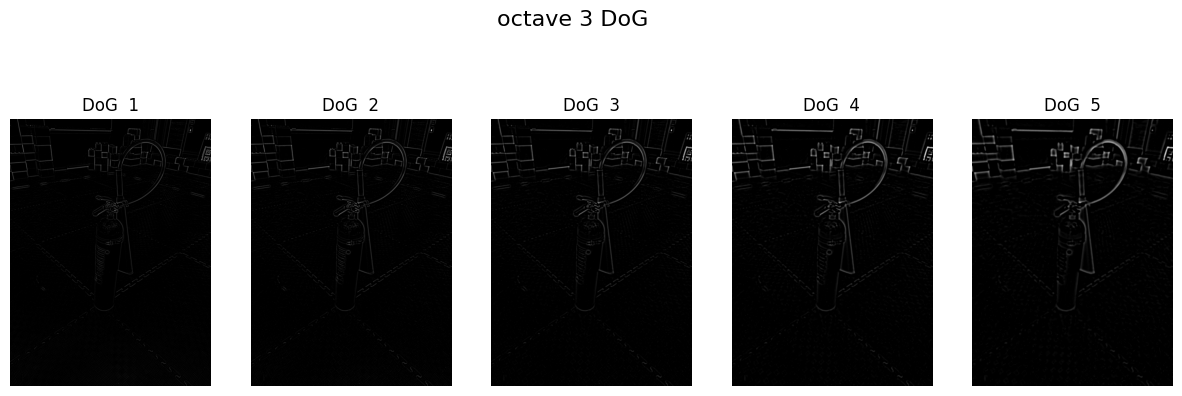

In [78]:
img = cv2.cvtColor(anchor_set[0], cv2.COLOR_RGB2GRAY)
sigma = 1.6
img = cv2.resize(img, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
img = cv2.GaussianBlur(img, (3,3), sigmaX = sigma, sigmaY = sigma)
dogs, gaussians = get_DoGs(img, sigma, 3)

def plot_imgs(imgs):
    num_images = len(imgs)
    num_rows = (num_images + 3 - 1) // 3 
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    axs = axs.ravel() if num_images > 1 else [axs]
    
    for i, img in enumerate(imgs):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off') 
    

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_dawgs(DoGs):
    for octave_idx, DoG_octave in enumerate(DoGs):
        num_dogs_in_octave = len(DoG_octave)
    
        fig, axs = plt.subplots(1, num_dogs_in_octave, figsize=(15, 5))
        fig.suptitle(f'octave {octave_idx + 1} DoG', fontsize=16)
        
        if num_dogs_in_octave == 1:
            axs = [axs] 
        
        for dog_idx, dog_img in enumerate(DoG_octave):
            axs[dog_idx].imshow(dog_img, cmap='gray')
            axs[dog_idx].set_title(f'DoG  {dog_idx + 1}')
            axs[dog_idx].axis('off')
        plt.show()

plot_imgs(gaussians[5])
plot_dawgs(dogs[:3])

In [6]:
def is_extrema(DoGs, i, y, x): # basically figure 2 of the paper
    # 3x3x3 region to check
    region = np.array([
        DoGs[i + 1][y - 1 : y + 2, x - 1 : x + 2], 
        DoGs[i    ][y - 1 : y + 2, x - 1 : x + 2],
        DoGs[i - 1][y - 1 : y + 2, x - 1 : x + 2]
    ])
    return region.argmax() == 13 or region.argmin == 13



asdasdasdasd